# Нейронные сети классификации изображений

# 3 Разветвленные сети, сеть NiN
Сети LeNet, AlexNet, и VGG работают по одному шаблону:
- извлекаем признаки из пространственной структуры данных, т.е. связываем ближайшие пиксели.
- полносвязная сеть типа многослойного персептрона классифицирует на основе таких признаков. При это в персептроне теряется пространственная информация, связываются *все* признаки.

Логичен вопрос, а почему бы не использовать полносвязные слои раньше, не только в конце. Если это делать обычным способом, то потеряется пространственная информация, которая для изображений может быть важна.

Нужно и не потерять пространственную информацию, и обработать признаки более сложным образом, чем просто свертка. Ответ - связывать только каналы.

Для этого подойдет свертка с ядром 1 на 1. Действительно, что делает такая **многоканальная** свертка? Берет входной признак с первого канала, умножает на единственный вес в первом ядре, берет признак второго канала, умножает его на вес второго ядра, и т.д., затем складывает результаты от всех каналов и добавляет смещение.

Абсолютно то же самое, что делает персептронный нейрон. Но для каналов, а не всего изображения целиком.

Получилась разветвленная архитектура, где каждый пиксель (признак) обрабатывается независимо от остальных. Как бы одна сеть - персептрон - применяется много раз для признаков другой сети, сеть в сети.



## NiN блоки
Такую сеть так и назвали Network in Network (NiN), состоит из блоков.

Первый слой в блоке - сверточный, с заданным размером ядра, связывает локально входные признаки, каждый фильтр дает свою карту признаков.

Следующие слои (в наших примерах два) связывают каналы признаков независимо для каждого признака, не меняют пространственную форму. Разумеется фильтров в таких слоях также несколько. Технически реализуются как свертка с ядром 1 на 1.    

На рис. показана архитектура блоков и самой сети NiN.

![img](https://d2l.ai/_images/nin.svg)

Между блоками используют слои субдискретизации. Отметим, что последний слой субдискретизации это слой 2D Global average pooling, который находит среднее значение для каждого канала входа.

![img](https://qph.cf2.quoracdn.net/main-qimg-a8c5cb77e38e589b3d7744c60ab5daad-pjlq)

Таким образом в сети **нет полносвязных слоев** в обычном понимании, на которые, как мы видели, приходятся основные вычислительные затраты. Число фильтров последнего блока определяется числом классов.



In [1]:
# установим вспомогательные функции из курса  d2l
!pip -q install d2l==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00


Зададим блоки NiN. Принимает аргументы:
- num_channels - число каналов (фильтров)
- kernel_size - размер сверточного слоя,
- strides - сдвиг для сверточного слоя,
- padding - набивка для него же.

Несмотря на разветвленную архитектуру все еще можем реализовать такую сеть в контейнере Sequential.

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l # вспомогательные функции для данных, обучения и отображения

# блоки NiN
def nin_block(num_channels, kernel_size, strides, padding):
    return tf.keras.models.Sequential([
        # сверточный слой с заданными параметрами
        tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides,
                               padding=padding, activation='relu'),
        # "полносвязный" слой для каналов
        tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu'),
        # "полносвязный" слой для каналов
        tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu')])

## Сеть NiN

Оригинальная сеть NiN использует сверточные слои в блоках с ядрами $11\times 11$, $5\times 5$, и $3\times 3$, такое же число фильтров, что и в AlexNet.

После блока NiN используют слой maxipooling со сдвигом 2 и ядром $3\times 3$.

В число каналов последнего блока совпадает с числом классов и используется слой *global average pooling*.



In [3]:
# Сеть NiN
def net():
    return tf.keras.models.Sequential([
        nin_block(96, kernel_size=11, strides=4, padding='valid'), # блок 1
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'), # блок 2
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'), # блок 3
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding='same'), # блок 4, число фильтров равно числу классов
        tf.keras.layers.GlobalAveragePooling2D(), # усреднение по пространственным измерениям
        #tf.keras.layers.Reshape((1, 1, 10)), # нужно преобразовать форму 4D тензора в 2D размером (batch size, 10)
        #tf.keras.layers.Flatten(), # и вытянуть в вектор
        ])

Проверим размерности выходов всех слоев. Первое измерение - примеры.

Посчитайте эти размерности самостоятельно, затем объясните вывод.



In [4]:
X = tf.random.uniform((1, 224, 224, 3))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)


In [5]:
input_shape=(None,224, 224, 3)
nn=net()
nn.build(input_shape)
nn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 54, 54, 96)        53568     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 sequential_6 (Sequential)   (None, 26, 26, 256)       746240    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 sequential_7 (Sequential)   (None, 12, 12, 384)       1180800   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 384)        

Обучим ~10-15 минут.


loss 0.333, train acc 0.877, test acc 0.875
1123.0 examples/sec on /GPU:0
CPU times: user 11min 34s, sys: 43.6 s, total: 12min 18s
Wall time: 11min 20s


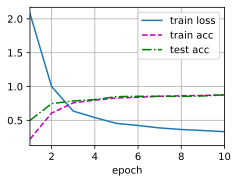

In [6]:
%%time
# параметры обучения
lr, num_epochs, batch_size = 0.1, 10, 128
# загружаем данные
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
# обучаем
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Задания

- Настройте гиперпараметры для большей аккуратности решения.
- Почему в блоке два слоя 1 на 1? Удалите и или добавьте еще один, как это отразится на результате?
- Посчитайте производительность NiN:
    - Сколько обучаемых параметров?
    - Сколько вычислительных операций (умножения)?
    - Объем памяти необходимый для сети?



# Ссылки
Использованы и адаптированы материалы

https://d2l.ai/chapter_convolutional-modern/nin.html